# K-Nearest-Neighbours (KNN)

**KNN er en af de simpleste algoritmer inden for ML. Så simpelt at den kan beskrives ved følgende operationer:**

1. **Start med $N$ forskellige træningspunkter, hver med deres egen klasse $j$. Eksempelvis kan vi sige 10 punkter, 4 af dem har klassen "rød", 6 af dem har klassen "blå"**
2. **Vælg en værdi til hyperparameteren "K". Den skal være et heltal**
3. **Kom med et af dine testpunkter, dvs. en af dem du ikke kender klassen på.**
4. **Lav en rangeret liste af hvilke træningspunkter der er tættest på dette nye testpunkt**.
5. **Vælg de $K$ første af disse træningspunkter, dvs. de $K$ af de træningspunkter der er tættest på dette testpunkt**
6. **Vælg klassen af det nye testpunkt ved at se hvad de fleste af disse $K$ "nærmeste naboer" har som punkt. Eksempelvis, hvis $K = 5$, og tre af de nærmeste punkter er klassen "rød" og to er klassen "blå", vil det nye punkt være klassen "rød"**
7. **Gentag for alle nye punkter.**
8. **OBS: Du bruger ikke forudsigelserne af testpunkterne til at bestemme klasserne af de nye punkter. Rækkefølgen du tager punkter ud til at teste må altså ikke have nogen effekt på hvad dine forudsigelser bliver**.

**I bund og grund kan dette koges ned til "lol, bare kig på hvad der er ved siden af det nye punkt". Det lyder måske for dumt til at virke, men det virker altså. Specielt når kombineret med andre metoder som preprocessering.**

**Implementationen af KNN er ligeledes også rimelig simpel, og er en af de få ML metoder man kan implementere, forstå, og benytte, uden meget matematisk intuition.**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

## Opgave 1: Data generering

**Ligesom med lineær regression, generer vi her noget data. Dette gør vi med nedenstående funktion. Dataen er normalfordelt med en forskellig fordeling for hver datapunkt. Det er nok den mest "klassiske" brug af KNN**

**1.1: Generer dataen og observer hvordan den ligger sig rundt omkring... Hvad gør det når du piller ved mean-værdien eller variansen af hver klasse?**

<span style="color:red">LØSNINGSFORSLAG: At pille ved mean værdien af hver klasse, vil flytte klassens 'centrum' længere mod den retning du piller mean værdien. At ændre variansen vil enten sprede eller samle punkterne af den respektive mere. </span>.

**1.2: Her har vi test data og træningsdata i samme plot, ligger test dataen godt ift. træningsdataen? Er det smart hvis testdata opfører sig på samme måde som træningsdata? Hvorfor / Hvorfor Ikke? HINT: flere svar kan måske være sande her...**

<span style="color:red">LØSNINGSFORSLAG: På en måde håber vi lidt at testdata afspejler testdata, da dette vil betyde at vores vores model kan trænes til også at klare test cases. På en måde så håber vi også at vores test data kan bruges til at udpeje hvis vores model er shit...</span>

<span style="color:red">...I virkeligheden håber vi på at vores testdata afspejler virkeligheden. Dette kan enten være ved at den minder om træningsdata, eller ved at den minder om testdata, either one can lede til en bedre model. </span>

In [3]:
def generate_knn_points(n, ls, class_params):
    """
    Generer n tilfældige punkter
    
    Parametre:
        n (int): Totale mængde af punkter.
        ls (list): Proportioner (procent) af hver klasse. 
                                Længden af listen giver hvor mange klasser der er 
        class_params (list): List af parametre for hver normalfordeling der genererer punkterne.
                                Hvert element skal være en tuple af parametre for hver klasse: 
                                (mean_x1, mean_x2, std_x1, std_x2).
    
    Returnerer:
        numpy.ndarray: Array med shape (n, 3) hvor hver række er [x1, x2, y].
                        x1, x2 er koordinater, y label.
    """
    # Check om givne værdier passer til funktionen
    if abs(sum(ls) - 1.0) > 1e-6:
        raise ValueError("Klasse proportionerne skal summe til én!")
    if len(ls) != len(class_params):
        raise ValueError("Mængde af klasser skal matche mængden af sæt af parametre!")

    points = []
    
    for i, proportion in enumerate(ls):
        # Mængden af punkter i denne klasse
        count = int(n * proportion)
        mean_x1, mean_x2, std_x1, std_x2 = class_params[i]

        # x værdier (features) for dette punkt
        x1 = np.random.normal(mean_x1, std_x1, count)
        x2 = np.random.normal(mean_x2, std_x2, count)
        y = np.full(count, i)
        
        points.append(np.column_stack((x1, x2, y)))
    
    return np.vstack(points)

# Eksempel brug
n = 100 # 100 datapunkter
ls = [0.4, 0.6] # 40 procent af den ene klasse, 60 procent af den anden
# klasse et har mean i 0,0 og varians 1,1
# klasse to har mean i 2,2 og varians 1,1
class_params = [(0, 0, 1, 1), (2, 2, 1, 1)] 
points = generate_knn_points(n, ls, class_params)

In [4]:
def split_train_test(data, train_ratio=0.8):
    """
    Split datasættet til træning og test tilfældigt
    """
    n = data.shape[0]
    indices = np.arange(n)

    # Shuffle indekser for at sikre tilfældighed
    np.random.shuffle(indices)

    # Find størrelse af træningssættet
    train_size = int(n * train_ratio)
    train_indices = indices[:train_size]

    # Resten af punkterne må være testsættet
    test_indices = indices[train_size:]

    train_set = data[train_indices]
    test_set = data[test_indices]

    return train_set, test_set

# Eksempel på brug
train_ratio = 0.8
train_set, test_set = split_train_test(points, train_ratio=train_ratio)

print(f"Train set shape: {train_set.shape}")
print(f"Test set shape: {test_set.shape}")


Train set shape: (80, 3)
Test set shape: (20, 3)


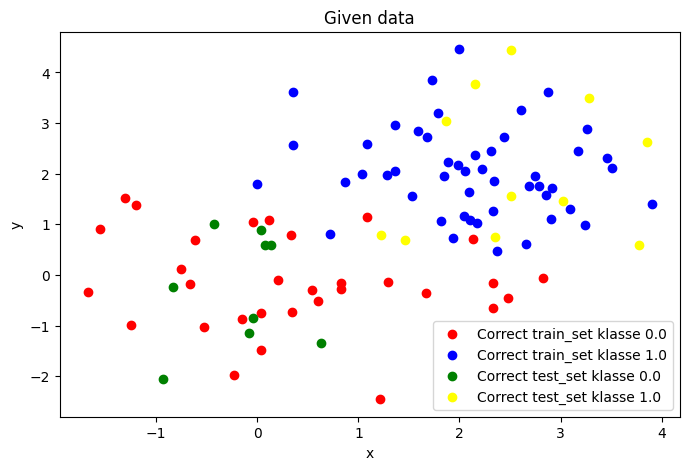

In [5]:
def plot_data(points_set, predictions_set=None, point_names=None):
    """
    Antager at points_set er liste af points... 
    hvor de hver især er af dimension [n, (x_0, x_1, ..., x_n, y)]
    """

    colors = ['red', 'blue', 'green', 'yellow', 'AMERICAN']

    # Hvis ingen points_names er givet, laver vi automatisk lige et
    if not point_names:
        point_names = [f"Set {i}" for i, _ in enumerate(points_set) ]
    # Hvis intet 'predictions' sæt er givet, laver vi bare et dummy sæt
    if predictions_set is None:
        predictions_set = [None] * len(points_set)
        
    plt.figure(figsize=(8, 5))
    for i, (points, preds) in enumerate(zip(points_set, predictions_set)):

        # Hvis ingen predictions er givet sætter vi bare "predicted" som aktuel klasse
        if preds is None:
            preds = points[:,-1]

        points = np.hstack((points, preds[:, None]))
        # Find mængde unikke labels fra dataen
        unique_labels = np.unique(points[:, -1])
        
        # Plot punkter baseret på deres /klasserlabels
        for r, label in enumerate(unique_labels):
            # Vælg alle punkter med den aktuelle klasse/label
            subset = points[points[:,-1] == label]
            correct = subset[subset[:,-1] == subset[:,-2]]
            misclassified = subset[subset[:,-1] != subset[:,-2]]

            plt.scatter(correct[:, 0], correct[:, 1], color=colors[r + i * len(unique_labels)],
                        label=f'Correct {point_names[i]} klasse {label}', marker='o')
            
            # Vi printer kun misclassifications hvis der rent faktisk er nogen...
            if len(misclassified) > 0:            
                plt.scatter(misclassified[:, 0], misclassified[:, 1], color=colors[r],
                            label=f'Misclassified som {label}', marker='x')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Given data')
    plt.show()

# Eksempel på brug
# plot_data([test_set], predictions_set=[result['predictions']], point_names=['test_set'])
plot_data([train_set, test_set], predictions_set=None, point_names=["train_set", 'test_set'])

## Opgave 2: KNN med Sklearn

**Selvom det måske føles antiklimatisk, så bruger vi altså "bare" en pakke til at lave KNN. Det er ikke kompliceret at lave selv, bare en hassle...**

**2.1: Test den givne model, hvor godt klarer den sig? Kan man forbedre dette ved at ændre på k?**

<span style="color:red">LØSNINGSFORSLAG: Tjah... vi kan nok godt finde en værdi af k hvor vi performer bedre på testdataen... om dette så er bedre for virkeligheden ved vi ikke, men må lidt godtage </span>

**2.2: Hvad ser der ud til at ske som man sætter k ned, tættere på 1?**

<span style="color:red">LØSNINGSFORSLAG: Modellen vil generelt blive mere "crazy". Beslutninger vil komme mere an på hvilke punkter der bare viser sig at være tæt på. Med andre ord, variansen stiger. </span>

**2.3: Hvad ser der ud til at ske som man sætter k op, tættere på uendelig?**

<span style="color:red">LØSNINGSFORSLAG: Som vi hæver k vil modellen bruge flere og flere nærmeste punkter til at bestemme hvad et givet punkt er. Når vi sætter k til uendelig vil modellen blot bruge den klasse der er flest til at afgøre hvad en given klasse er. Dette svarer lidt til at lave en lineær regressionsmodel som altid gætter på gennemsnittet. Max bias, minimal varians.</span>

**2.4: Hvad siger din intuition, er KNN en lineær eller en ikke-lineær model?**

<span style="color:red">LØSNINGSFORSLAG: Min meget ydmyge intuition, siger at det er en *herre meget* ikke-lineær model.</span>

**2.5: Nogle kalder KNN for en "lazy learning" algoritme... hvad tror du dette hentyder til?**

<span style="color:red">LØSNINGSFORSLAG: At KNN er lazy-learning (bruges ikke sååå ofte det koncept), betyder bare at vi ikke behøver træne den på nogen måde. Ingen tid bruges på at fitte parametre. Alt computation tid bruges udelukkende på at lave predictions om nye datapunkter.</span>

Predicted Labels: [0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
Accuracy: 0.90


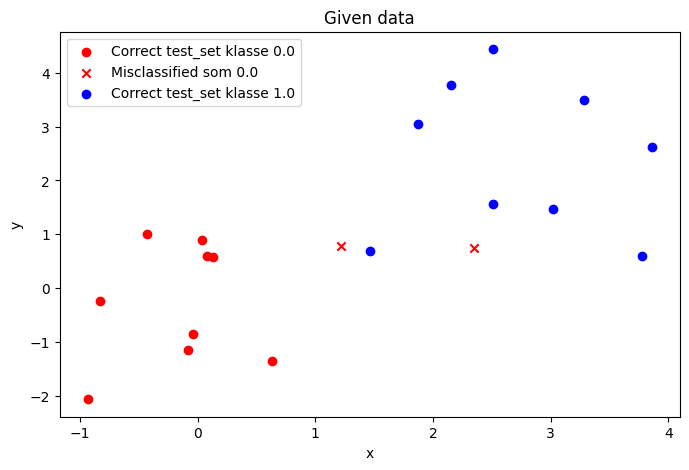

In [6]:
def knn_sklearn(train_set, test_set, k=3):
    """
    Brug sklearn til at lave KNN på træning- og test-sæt

    Parametre:
        train_set (numpy.ndarray): Træningssæt med form [n_train, (x1, x2, y)].
        test_set (numpy.ndarray): Test sæt med form [n_test, (x1, x2, y)].
        k (int): Mængden af 'naboer' vi kigger efter(default is 3).

    Returns:
        dict: Et dictionary som indeholder predictions, accuracy, og classifier'en
    """
    # Find features af træning og derefter test sættet,
    # Vi antager at alt før den sidste må være features
    X_train = train_set[:, :-1]
    y_train = train_set[:, -1]
    X_test = test_set[:, :-1]
    y_test = test_set[:, -1]

    # Lav KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit modellen på træningssættet
    knn.fit(X_train, y_train)

    # Predict labels på test sættet
    y_pred = knn.predict(X_test)

    # Udregn accuracy af predictions
    accuracy = accuracy_score(y_test, y_pred)

    return {
        'predictions': y_pred,
        'accuracy': accuracy,
        'classifier': knn
    }

# Eksempel på brug:
result = knn_sklearn(train_set, test_set, k=1)
print(f"Predicted Labels: {result['predictions']}")
print(f"Accuracy: {result['accuracy']:.2f}")

# Eksempel på brug
plot_data([test_set], predictions_set=[result['predictions']], point_names=['test_set'])

## Opgave 3: KNN og decision boundaries

**En smart ting for at give noget intuition om klassifikations modeller, er at kigge på deres "decision boundaries". Dette svarer lidt til at gætte på hvornår en regressionsmodel kommer frem til de resultater som den gør.**

**3.1: Kig på de decision boundaries der er. Hvor kan man sige modellen er mest usikker om punkter?**

<span style="color:red">LØSNINGSFORSLAG: Modellen er generelt mest usikker de steder hvor der er mange forskellige klasser i nærheden. Hvis det er lige mellem 2 af en klasse og 2 af en anden klasse eksempelvis, kan blot en lille ændring gøre den en eller en anden klasse! </span>

**3.2: Genovervej din stance fra tidligere, tror du at KNN er en lineær eller ikke-lineær model?**

<span style="color:red">LØSNINGSFORSLAG: Stadigvæk: Pisse ikke-lineær. Dette ses klart fra faktum af, at det ikke er en lige linje som adskiller de to klasser (de to farver)</span>

**3.3: Prøv nu at ændre på k igen, hvad sker der med de givne decision boundaries når du sætter den op eller ned?**

<span style="color:red">LØSNINGSFORSLAG: Når vi sætter k ned, kan vi se at der kommer mere "hakkede" decision boundaries, og ovenikøbet små "øer" af den ene eller den anden farve. Som k sættes op bliver decision boundaries mere veldefineret ala hvad vi ville forvente med en lineær model</span>

<span style="color:red">Denne evne til at lave "øer (decision boundaries der ikke hænger sammen)" af den ene eller anden klasse, er faktisk meget svært at lave uden at bruge meget kompliceret modeller såsom neurale netværk. </span>

**3.4: Hvordan kan k have en indflydelse på modellens bias og varians tror du?**

<span style="color:red">LØSNINGSFORSLAG: Højere k = mere bias men mindre varians, lavere k = mere varians, mindre bias</span>

**3.5: Sæt k=70, hvad sker der med decision boundaries? Hvad svarer den resulterende model til?**

<span style="color:red">LØSNINGSFORSLAG: Dette vil være ekstremtilfældet hvor den bare gætter på den klasse der er mest af. Hvorfor lige 70? Det er fordi den specifikke vi bruger må ikke have k > mængden af datapunkter vi har, og 70 er flere end der er røde datapunkter.</span>

In [7]:
def plot_data_with_boundaries(classifier, points_set, predictions_set=None, point_names=None, resolution=0.02):
    colors = ['red', 'blue', 'green', 'purple', 'orange']
    
    if not point_names:
        point_names = [f"Set {i}" for i in range(len(points_set))]
    if predictions_set is None:
        predictions_set = [None] * len(points_set)

    all_points = np.vstack(points_set)
    x_min, x_max = all_points[:, 0].min() - 1, all_points[:, 0].max() + 1
    y_min, y_max = all_points[:, 1].min() - 1, all_points[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

    for i, (points, preds) in enumerate(zip(points_set, predictions_set)):
        if preds is None:
            preds = points[:, -1]

        points = np.hstack((points, preds[:, None]))
        unique_labels = np.unique(points[:, -1])

        for r, label in enumerate(unique_labels):
            subset = points[points[:, -1] == label]
            correct = subset[subset[:, -1] == subset[:, -2]]
            misclassified = subset[subset[:, -1] != subset[:, -2]]

            # Choose marker based on whether it's test or train
            marker_correct = '*' if 'test' in point_names[i].lower() else 'o'

            plt.scatter(correct[:, 0], correct[:, 1], color=colors[r % len(colors)],
                        label=f'Correct {point_names[i]} klasse {label}', marker=marker_correct)
            if len(misclassified) > 0:
                plt.scatter(misclassified[:, 0], misclassified[:, 1], color=colors[r % len(colors)],
                            label=f'Misclassified som klasse {label}', marker='x')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Decision Boundaries and Data Points')
    plt.legend()
    plt.show()


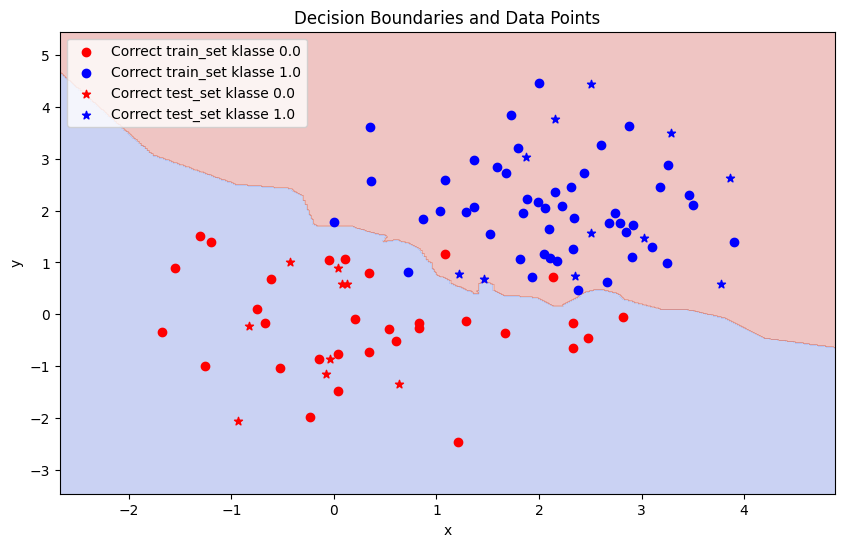

In [8]:
result = knn_sklearn(train_set, test_set, k=5)
plot_data_with_boundaries(result['classifier'], [train_set, test_set],
                          predictions_set=[None, result['predictions']],
                          point_names=["train_set", "test_set"])
